In [1]:
%load_ext autoreload
%autoreload 2

from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, classification_report, precision_recall_fscore_support
from sklearn.externals import joblib
from sklearn import datasets, linear_model

import numpy as np
import cPickle as pickle
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 950M (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5005)


In [2]:
paths = ['../models', '../rainforest', '../scripts']
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
        
import dataset
from data import *
from data_generators_leo import get_data, get_data_channels_last
from preprocess import *

data_path = '..\\data\\'
jpg_path = data_path + 'train-jpg'
batch_size=20

weather_labels = ['clear', 'cloudy', 'haze', 'partly_cloudy']
train_csv = get_class_data(train=True, label='weather')
val_csv = get_class_data(train=False, label='weather')

train_labels = np.asarray(train_csv)[:,1:5]
train_data = np.asarray(train_csv)[:,0]
all_zeros_train = [index for index, label in enumerate(train_labels) if sum(label) == 0]
if(all_zeros_train > 0):
    train_data = np.delete(train_data, all_zeros_train)
    train_labels = np.delete(train_labels, all_zeros_train, axis=0)

val_labels = np.asarray(val_csv)[:,1:5]
val_data = np.asarray(val_csv)[:,0]
all_zeros_val = [index for index, label in enumerate(val_labels) if sum(label) == 0]
if(all_zeros_val > 0):
    val_data = np.delete(val_data, all_zeros_val)
    val_labels = np.delete(val_labels, all_zeros_val, axis=0)

print(train_labels.shape)
print(train_data.shape)
print(val_labels.shape)
print(val_data.shape)

(28334L, 4L)
(28334L,)
(12144L, 4L)
(12144L,)


In [3]:
#train_gen = get_data(train_data, '..\\data\\train-jpg', train_labels, 
                                      #flip=True, shift_x=5, shift_y=5, rot_range=10,
                                      #elastic_trans=False, batch_size=8, balance_batches=True)

train_gen = get_data(train_data, jpg_path, train_labels, batch_size=batch_size, augmentation=True,
                    hflip=True, vflip=True, shift_x=5, shift_y=5, rot_range=10,
                    elastic_trans=False, img_size=(92, 92), balance_batches=True)

val_gen = get_data(val_data, jpg_path, val_labels, augmentation=False,
                   batch_size=batch_size, img_size=(92,92), balance_batches=True)

#train_gen = get_data_channels_last(train_data, jpg_path, train_labels, batch_size=batch_size, augmentation=False,
#                      img_size=(256,256), balance_batches=True)
        
#val_gen = get_data(val_data, jpg_path, val_labels, augmentation=False,
#                   batch_size=batch_size, img_size=(256,256), balance_batches=True)
 

In [4]:
# from sklearn import datasets, neighbors, linear_model
# from sklearn.ensemble import RandomForestClassifier
# from skimage.feature import greycomatrix, greycoprops
# from scipy import stats
# from tqdm import tqdm

# data_train = train_data 
# labels_train = train_labels
# data_val = val_data
# labels_val = val_labels

# X_train = np.zeros((len(data_train),16))
# y_train = np.zeros((len(data_train),4))
# X_val = np.zeros((len(data_val),16))
# y_val = np.zeros((len(data_val),4))

# for i in tqdm(range(len(data_train))):
#     img_name = data_train[i]
#     label = labels_train[i]
#     img_name = img_name + ".jpg"
#     img_path = os.path.join(jpg_path, img_name)
#     img = load_image(img_path)
#     img = img[:,:,:3]

#     X_train[i,0] = np.mean(img[:,:,0])
#     X_train[i,1] = np.mean(img[:,:,1])
#     X_train[i,2] = np.mean(img[:,:,2])

#     X_train[i,3] = np.mean(stats.skew(img[:,:,0]))
#     X_train[i,4] = np.mean(stats.skew(img[:,:,1]))
#     X_train[i,5] = np.mean(stats.skew(img[:,:,2]))

#     X_train[i,6] = np.mean(stats.kurtosis(img[:,:,0]))
#     X_train[i,7] = np.mean(stats.kurtosis(img[:,:,1]))
#     X_train[i,8] = np.mean(stats.kurtosis(img[:,:,2]))
    
#     X_train[i,9] = np.std(img[:,:,0])
#     X_train[i,10] = np.std(img[:,:,1])
#     X_train[i,11] = np.std(img[:,:,2])
    
#     mean_img = np.mean(img, axis=2)
#     X_train[i,12] = (mean_img > 225).sum()
#     X_train[i,13] = (mean_img < 30).sum()
    
#     X_train[i,14] = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).var()
#     X_train[i,15] = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).var()
    
#     y_train[i,:] = label
    
# for i in tqdm(range(len(data_val))):
#     img_name = data_val[i]
#     label = labels_val[i]
#     img_name = img_name + ".jpg"
#     img_path = os.path.join(jpg_path, img_name)
#     img = load_image(img_path)
#     img = img[:,:,:3]
    
#     X_val[i,0] = np.mean(img[:,:,0])
#     X_val[i,1] = np.mean(img[:,:,1])
#     X_val[i,2] = np.mean(img[:,:,2])

#     X_val[i,3] = np.mean(stats.skew(img[:,:,0]))
#     X_val[i,4] = np.mean(stats.skew(img[:,:,1]))
#     X_val[i,5] = np.mean(stats.skew(img[:,:,2]))
    
#     X_val[i,6] = np.mean(stats.kurtosis(img[:,:,0]))
#     X_val[i,7] = np.mean(stats.kurtosis(img[:,:,1]))
#     X_val[i,8] = np.mean(stats.kurtosis(img[:,:,2]))
    
#     X_val[i,9] = np.std(img[:,:,0])
#     X_val[i,10] = np.std(img[:,:,1])
#     X_val[i,11] = np.std(img[:,:,2])
    
#     mean_img = np.mean(img, axis=2)
#     X_val[i,12] = (mean_img > 225).sum()
#     X_val[i,13] = (mean_img < 30).sum()
        
#     X_val[i,14] = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).var()
#     X_val[i,15] = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).var()
    
#     y_val[i,:] = label

In [5]:
# # Create a random forest classifier
# clf = RandomForestClassifier(n_estimators=300, n_jobs=3)

# # Train the classifier to take the training features and learn how they relate
# # to the training
# clf.fit(X_train, y_train)

# # Apply the classifier we trained to the test data
# pred = clf.predict(X_val)

# result = [1 for x,y in zip(pred,y_val) if np.argmax(x) == np.argmax(y)]
# accuracy = float(sum(result)/float(len(y_val)))

# print("Accuracy is:")
# print(accuracy)

# print(classification_report(y_val, pred, target_names=weather_labels))

In [6]:
# # Create a random forest classifier
# clf = RandomForestClassifier(n_estimators=300, n_jobs=3)

# y_train_new = np.asarray([np.argmax(x) for x in y_train])
# y_val_new = np.asarray([np.argmax(x) for x in y_val])

# # Train the classifier to take the training features and learn how they relate
# # to the training
# clf.fit(X_train, y_train_new)

# # Apply the classifier we trained to the test data and print for multiple thresholds
# pred_proba = clf.predict_proba(X_val)
# pred_proba = np.asarray(pred_proba)

# print("Original f2 score without probabilities")
# print([0.95384615, 0.74471033, 0.6075419, 0.75])

# print("Scores with best probability threshold")
# pred = np.asarray([(x > 0.2).astype(int) for x in pred_proba])
# print("Threshold 0.2")
# print("Precision: ") 
# print(precision_recall_fscore_support(y_val, pred, beta=2.0)[0])
# print("Recall: ") 
# print(precision_recall_fscore_support(y_val, pred, beta=2.0)[1])
# print("F2-score: ")
# print(precision_recall_fscore_support(y_val, pred, beta=2.0)[2])

In [7]:
# x=10

# mean_clear = np.zeros((x,3))
# mean_cloudy = np.zeros((x,3))
# mean_haze = np.zeros((x,3))
# mean_partly = np.zeros((x,3))

# for j in range(x):  
#     batch = train_gen.next()
    
#     batch_clear = np.zeros((batch_size/4,3))
#     batch_cloudy = np.zeros((batch_size/4,3))
#     batch_haze = np.zeros((batch_size/4,3))
#     batch_partly = np.zeros((batch_size/4,3))
    
#     clear = 0
#     cloudy = 0
#     haze = 0
#     partly = 0

#     for i in range(batch[0].shape[0]):
#         image = batch[0][i,:,:,:]
        
#         if(batch[1][i,0] == 1):
#             batch_clear[clear,0] = np.mean(image[:,:,0])
#             batch_clear[clear,1] = np.mean(image[:,:,1])
#             batch_clear[clear,2] = np.mean(image[:,:,2])
#             clear = clear+1
#         if(batch[1][i,1] == 1):
#             batch_cloudy[cloudy,0] = np.mean(image[:,:,0])
#             batch_cloudy[cloudy,1] = np.mean(image[:,:,1])
#             batch_cloudy[cloudy,2] = np.mean(image[:,:,2])
#             cloudy = cloudy+1
#         if(batch[1][i,2] == 1):
#             batch_haze[haze,0] = np.mean(image[:,:,0])
#             batch_haze[haze,1] = np.mean(image[:,:,1])
#             batch_haze[haze,2] = np.mean(image[:,:,2])
#             haze = haze+1
#         if(batch[1][i,3] == 1):
#             batch_partly[partly,0] = np.mean(image[:,:,0])
#             batch_partly[partly,1] = np.mean(image[:,:,1])
#             batch_partly[partly,2] = np.mean(image[:,:,2])
#             partly = partly+1
    
#     mean_clear[j,0] = np.mean(batch_clear[:,0])
#     mean_clear[j,1] = np.mean(batch_clear[:,1])
#     mean_clear[j,2] = np.mean(batch_clear[:,2])
#     mean_cloudy[j,0] = np.mean(batch_cloudy[:,0])
#     mean_cloudy[j,1] = np.mean(batch_cloudy[:,1])
#     mean_cloudy[j,2] = np.mean(batch_cloudy[:,2])
#     mean_haze[j,0] = np.mean(batch_haze[:,0])
#     mean_haze[j,1] = np.mean(batch_haze[:,1])
#     mean_haze[j,2] = np.mean(batch_haze[:,2])
#     mean_partly[j,0] = np.mean(batch_partly[:,0])
#     mean_partly[j,1] = np.mean(batch_partly[:,1])
#     mean_partly[j,2] = np.mean(batch_partly[:,2])
    
# print("Clear is:")
# print(mean_clear)
# print(np.mean(mean_clear[:,0]),np.mean(mean_clear[:,1]),np.mean(mean_clear[:,2]))
# print("Cloudy is:")
# print(mean_cloudy)
# print(np.mean(mean_cloudy[:,0]),np.mean(mean_cloudy[:,1]),np.mean(mean_cloudy[:,2]))
# print("Haze is:")
# print(mean_haze)
# print(np.mean(mean_haze[:,0]),np.mean(mean_haze[:,1]),np.mean(mean_haze[:,2]))
# print("Partly is:")
# print(mean_partly)
# print(np.mean(mean_partly[:,0]),np.mean(mean_partly[:,1]),np.mean(mean_partly[:,2]))

(20L, 3L, 92L, 92L)
(92L, 92L, 3L)
[1 0 0 0]
()


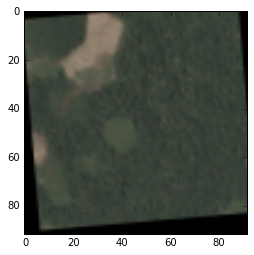

(92L, 92L, 3L)
[1 0 0 0]
()


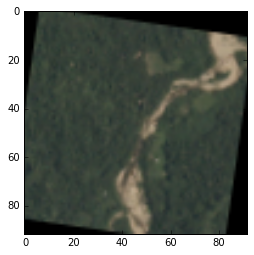

(92L, 92L, 3L)
[0 0 0 1]
()


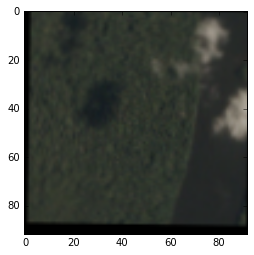

(92L, 92L, 3L)
[1 0 0 0]
()


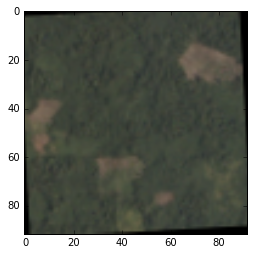

(92L, 92L, 3L)
[1 0 0 0]
()


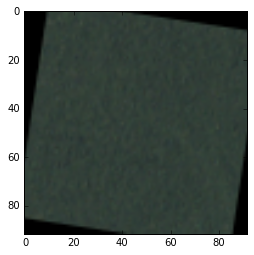

(92L, 92L, 3L)
[1 0 0 0]
()


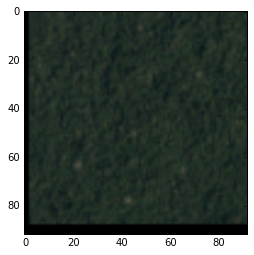

(92L, 92L, 3L)
[0 1 0 0]
()


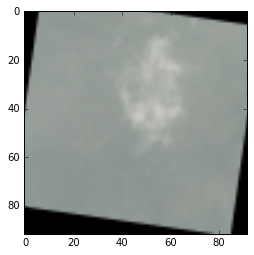

(92L, 92L, 3L)
[0 0 0 1]
()


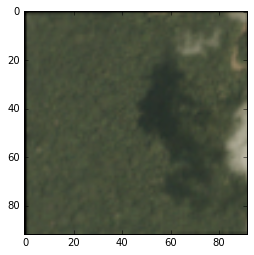

(92L, 92L, 3L)
[0 0 0 1]
()


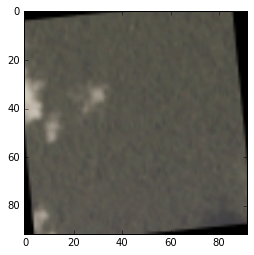

(92L, 92L, 3L)
[0 0 0 1]
()


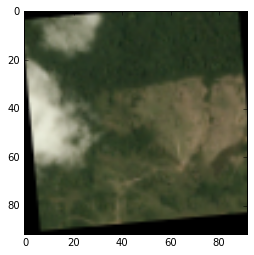

(92L, 92L, 3L)
[0 1 0 0]
()


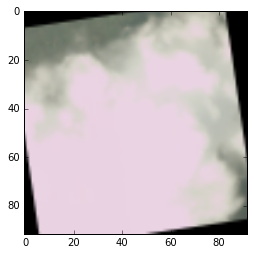

(92L, 92L, 3L)
[0 1 0 0]
()


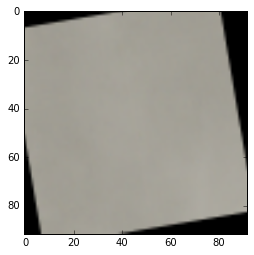

(92L, 92L, 3L)
[0 0 1 0]
()


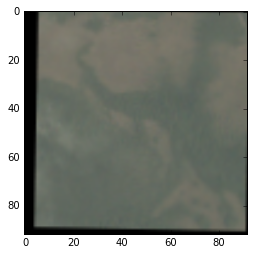

(92L, 92L, 3L)
[0 0 0 1]
()


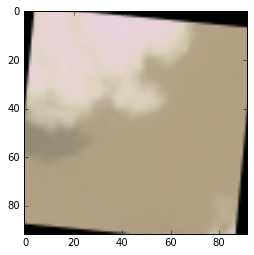

(92L, 92L, 3L)
[0 0 1 0]
()


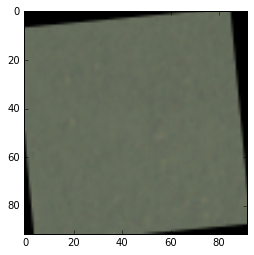

(92L, 92L, 3L)
[0 1 0 0]
()


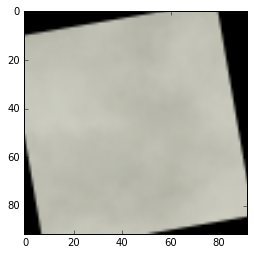

(92L, 92L, 3L)
[0 0 1 0]
()


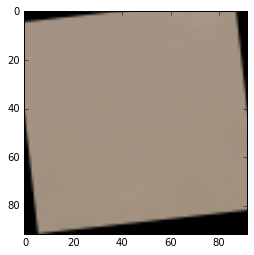

(92L, 92L, 3L)
[0 1 0 0]
()


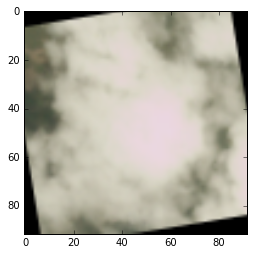

(92L, 92L, 3L)
[0 0 1 0]
()


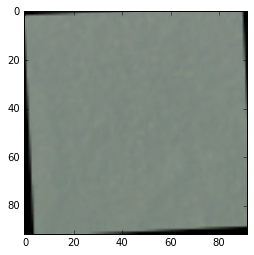

(92L, 92L, 3L)
[0 0 1 0]
()


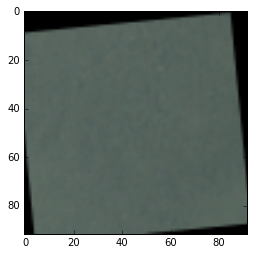

In [4]:
batch = train_gen.next()
print(batch[0].shape)

for i in range(batch[0].shape[0]):
    img = batch[0][i,:,:,:]
    
    img = np.transpose(img, (1,2,0))
    print(img.shape)
    print(batch[1][i])
    print()
    plt.figure()
    plt.imshow(img)
    plt.show()

In [9]:
# model = VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# for layer in model.layers:
#     layer.trainable = False
    
# layer = Flatten()(model.output)
# layer = BatchNormalization()(layer)
# layer = Dense(512, activation='relu')(layer)
# layer = BatchNormalization()(layer)

# output_layer = Dense(len(weather_labels), activation='softmax')(layer)

# model = Model(inputs=model.input, outputs=output_layer)
# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(),
#               metrics=['accuracy'])

# model.summary()

In [5]:
model = Sequential()

model.add(BatchNormalization(axis=1,  input_shape=(3, 92, 92)))

model.add(Conv2D(16, (3, 3), activation='relu'))
#model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(weather_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy', 'categorical_crossentropy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3, 92, 92)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 90, 90)        448       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 90, 90)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 45, 45)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 45, 45)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 43, 43)        4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 43, 43)        128       
__________

In [11]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=[3, 256, 256]))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(len(weather_labels), activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#              optimizer=Adam(),
#              metrics=['accuracy', 'categorical_crossentropy'])

# model.summary()

In [ ]:
# model = Sequential()

# model.add(Conv2D(16, (3, 3), activation='relu', input_shape=[3, 92, 92]))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(len(weather_labels), activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#              optimizer=Adam(),
#              metrics=['accuracy', 'categorical_crossentropy'])

# model.summary()

In [ ]:
csv_logger = CSVLogger('run4_adam.csv')
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5)
checkpoint = ModelCheckpoint(filepath='E:/KI/Master/MLIP/Brainforest/WeatherTest/ccmdccmdccmdfcd/model.{epoch:02d}-{val_loss:.2f}.hdf5',
                             verbose=1, save_best_only=True)

model.fit_generator(train_gen, steps_per_epoch=len(train_data)/batch_size,
                    epochs=100, verbose=2,
                    callbacks=[csv_logger, lr_plateau, checkpoint],
                    validation_data=val_gen, validation_steps=len(val_data)/batch_size)

Epoch 1/100
Epoch 00000: val_loss improved from inf to 3.12485, saving model to E:/KI/Master/MLIP/Brainforest/WeatherTest/ccmdccmdccmdfcd/model.00-3.12.hdf5
166s - loss: 1.3262 - acc: 0.3786 - categorical_crossentropy: 1.3262 - val_loss: 3.1249 - val_acc: 0.3671 - val_categorical_crossentropy: 3.1249
Epoch 2/100
Epoch 00001: val_loss improved from 3.12485 to 1.42069, saving model to E:/KI/Master/MLIP/Brainforest/WeatherTest/ccmdccmdccmdfcd/model.01-1.42.hdf5
86s - loss: 1.2816 - acc: 0.3904 - categorical_crossentropy: 1.2816 - val_loss: 1.4207 - val_acc: 0.4301 - val_categorical_crossentropy: 1.4207
Epoch 3/100
Epoch 00002: val_loss improved from 1.42069 to 1.33194, saving model to E:/KI/Master/MLIP/Brainforest/WeatherTest/ccmdccmdccmdfcd/model.02-1.33.hdf5
86s - loss: 1.2780 - acc: 0.3990 - categorical_crossentropy: 1.2780 - val_loss: 1.3319 - val_acc: 0.3972 - val_categorical_crossentropy: 1.3319
Epoch 4/100
Epoch 00003: val_loss improved from 1.33194 to 1.22752, saving model to E:/K

In [7]:
model = load_model('E:/KI/Master/MLIP/Brainforest/WeatherTest/ccmdccmdccmdfcd/model.16-1.14.hdf5')

val_gen_predict = get_data(val_data, jpg_path, val_labels, augmentation=False,
                   batch_size=batch_size, img_size=(92, 92), shuffle=False)

val_steps = int(np.ceil(float(len(val_data)) / float(batch_size)))
preds = model.predict_generator(val_gen_predict, val_steps)
preds = preds[:len(val_data)]

f2 score clear:

ValueError: Can't handle mix of unknown and binary

In [21]:
y_true_clear = (val_labels[:,0]).astype(int)
y_true_cloudy = (val_labels[:,1]).astype(int)
y_true_haze = (val_labels[:,2]).astype(int)
y_true_partly_cloudy = (val_labels[:,3]).astype(int)

y_pred_clear = (preds[:,0] > 0.3).astype(int)
y_pred_cloudy = (preds[:,1] > 0.3).astype(int)
y_pred_haze = (preds[:,2] > 0.3).astype(int)
y_pred_partly_cloudy = (preds[:,3] > 0.3).astype(int)

print 'f2 score clear:', fbeta_score(y_true_clear, y_pred_clear, 2)
print 'f2 score cloudy:', fbeta_score(y_true_cloudy, y_pred_cloudy, 2)
print 'f2 score haze:', fbeta_score(y_true_haze, y_pred_haze, 2)
print 'f2 score partly cloudy:', fbeta_score(y_true_partly_cloudy, y_pred_partly_cloudy, 2)

f2 score clear: 0.867957285894
f2 score cloudy: 0.79408543264
f2 score haze: 0.634935836047
f2 score partly cloudy: 0.735799944222


In [ ]:
# model.load_weights("../../WeatherTest/model.00-9.72.hdf5")
# imgs, labels = next(val_gen)
# prediction = model.predict(imgs)
# for i in range(len(labels)):
#     print(labels[i], prediction[i])